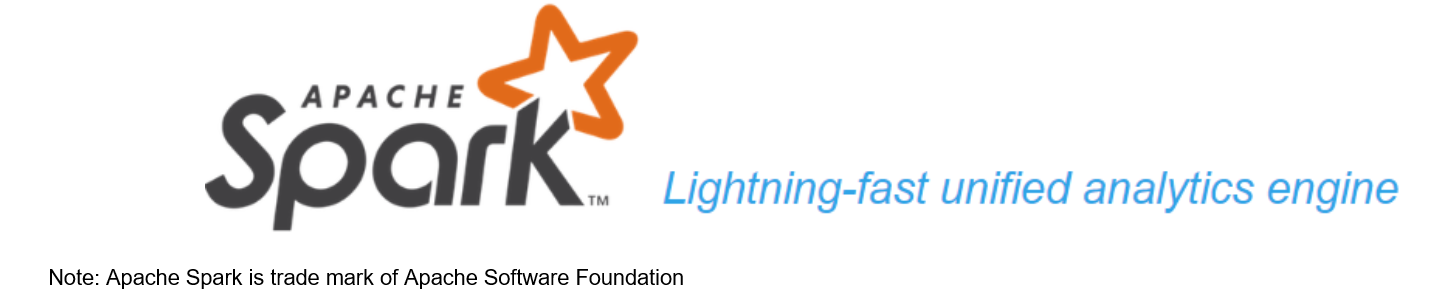

# <a href="http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#" target=_blank>Spark Structured API</a>

The Structured APIs are a tool for manipulating all sorts of data, from unstructured log files to semi-structured CSV files and highly structured Parquet files. These APIs refer to three core types of distributed collection APIs:

- Datasets: A Dataset is a distributed collection of data. The Dataset API is available in Scala and Java. Python does not have the support for the Dataset API.

- DataFrames: A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

- SQL tables and views: One use of Spark SQL is to execute SQL queries.

# Overview of Structured API Execution

1. Write DataFrame/Dataset/SQL Code.

2. If valid code, Spark converts this to a Logical Plan.

3. Spark transforms this Logical Plan to a Physical Plan, checking for optimizations along the way.

4. Spark then executes this Physical Plan (RDD manipulations) on the cluster.

In [ ]:
# class pyspark.sql.SparkSession, The entry point to programming Spark with the Dataset and DataFrame API.
#A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over tables, cache tables, and 
# read parquet files.To create a SparkSession, use the following builder pattern:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("PySpark DataFrame and Sql") \
    .getOrCreate()

# Create DataFrames

In [ ]:
# Datafram can be created by by calling read method on spark object
#The foundation for reading data in Spark is the DataFrameReader. We access this through the SparkSession via the 
#read attribute: spark.read => http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReade
df = spark.read.format("json").load("/common_folder/pyspark_data/flight-data/json/2015-summary.json")
df

In [ ]:
#DataFame will have columns, and we use a schema to define them.
df.printSchema()

# printSchema returns schema in tree format

In [ ]:
df.schema
#Returns the schema of this DataFrame as a pyspark.sql.types.StructType.

In [ ]:
#A schema defines the column names and types of a DataFrame. We can either let a data source define the schema
# (called schema-on-read) or we can define it explicitly ourselves.
#A schema is a StructType made up of a number of fields, StructFields, that have a name, type, a Boolean flag which
#specifies whether that column can contain missing or null values, and, finally, users can optionally specify associated
#metadata with that column.

from pyspark.sql.types import StructField, StructType, StringType, LongType

myManualSchema = StructType([
  StructField("DEST_COUNTRY_NAME", StringType(), True),
  StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
  StructField("count", LongType(), False, metadata={"hello":"world"})
])
df = spark.read.format("json").schema(myManualSchema)\
  .load("/common_folder/pyspark_data/flight-data/json/2015-summary.json")

In [ ]:
df.printSchema()

In [ ]:
# COLUMNS AS EXPRESSIONS
''' you can refer to columns in a number of different ways; all you need to keep in mind is that you can use them 
interchangeably'''

from pyspark.sql.functions import expr, col, column
df.select(
    expr("DEST_COUNTRY_NAME"),
    col("DEST_COUNTRY_NAME"),
    column("DEST_COUNTRY_NAME"))\
  .show(2)

In [ ]:
# Rename the column
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

In [ ]:
# Remove the column
dfdrop=df.drop("ORIGIN_COUNTRY_NAME").columns

In [ ]:
dfdrop

In [ ]:
df.printSchema()

In [ ]:
# Changing column types
df.withColumn("count2", col("count").cast("Int"))

In [ ]:
# Above equivalent sql syntax
# register DataFrame as temp table
df.createOrReplaceTempView("dfTable")
# after registering temp table you can run your sql queries
spark.sql('SELECT *, cast(count as Int) AS count2 FROM dfTable').show

In [ ]:
'''In Spark, each row in a DataFrame is a single record. Spark represents this record as an object of type Row.'''
from pyspark.sql import *

# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@gmail.com', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@gmail.com', 120000)
employee3 = Employee('matei', None, 'no-reply@gmail.com', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@gmail.com', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])
employee1, employee4

In [ ]:
print(department1)
print(employee2)
print (departmentWithEmployees1)

# Create DataFrames from a list of the rows

In [ ]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)
df2.take(2)

# Work with DataFrames
Union two DataFrames


In [ ]:
unionDF = df1.unionAll(df2)
display(unionDF)
unionDF.show()

# Write the unioned DataFrame to a Parquet file

In [ ]:
unionDF.write.parquet("/common_folder/pyspark_data/flight-data/unionDF.parquet")

In [ ]:
parquetDF = spark.read.parquet("/common_folder/pyspark_data/flight-data/unionDF.parquet")

In [ ]:
display(parquetDF)
parquetDF.show()
parquetDF.collect()

# Explode the employees column

In [ ]:
unionDF.show()

In [ ]:
# pyspark.sql.functions.explode 
#Returns a new row for each element in the given array or map.
from pyspark.sql.functions import explode
df = unionDF.select(explode("employees").alias("e"))
df.show()

In [ ]:
explodeDF = df.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

In [ ]:
explodeDF.show()

# Use filter() to return the rows that match a predicate


In [ ]:
filterDF = explodeDF.filter(explodeDF.firstName == "xiangrui").sort(explodeDF.lastName)

In [ ]:
display(filterDF)
filterDF.show()

In [ ]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = explodeDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(filterDF)
filterDF.show()

 # The where() clause is equivalent to filter()


In [ ]:
whereDF = explodeDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(whereDF)
whereDF.collect()

# Replace null values with using DataFrame Na function

In [ ]:
explodeDF.show()

In [ ]:
#Drop records with null value
dropNullDF = explodeDF.na.drop()

In [ ]:
dropNullDF.show()

# Retrieve only rows with missing firstName or lastName


In [ ]:
filterNonNullDF = explodeDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")

In [ ]:
filterNonNullDF.show()

# Example aggregations using agg() and countDistinct()

In [ ]:
from pyspark.sql.functions import countDistinct

countDistinctDF = explodeDF.select("firstName", "lastName")\
  .groupBy("firstName", "lastName")\
  .agg(countDistinct("firstName"))

countDistinctDF.take(5)

# Compare the DataFrame and SQL query physical plans


In [ ]:
countDistinctDF.explain()

In [ ]:
#we will also register this as a temporary view so that we can query it with SQL and show off basic transformations in SQL
explodeDF.registerTempTable("upgrade_df_table")

In [ ]:
countDistinctDF_sql = spark.sql("SELECT firstName, lastName, count(distinct firstName) as distinct_first_names FROM upgrade_df_table GROUP BY firstName, lastName")

In [ ]:
countDistinctDF_sql.take(4)

In [ ]:
countDistinctDF_sql.explain()

In [ ]:
salarySumDF = explodeDF.agg({"salary" : "sum"})

In [ ]:
salarySumDF.take(2)

In [ ]:
type(explodeDF.salary)

 # Print the summary statistics for the salaries


In [ ]:
explodeDF.describe("salary").show()

# An example using pandas and Matplotlib integration


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = dropNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)

# Aggregation

In [ ]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("/common_folder/pyspark_data/retail-data/*.csv")\
  .coalesce(5)
# cache dataframe for better performance
df.cache()
df.createOrReplaceTempView("dfTable")

In [ ]:
df = df.limit(10)
#df.take(5) # take works with an Integer count
#df.show(5) # this prints it out nicely
df.show(5, False)
#df.collect()

In [ ]:
from pyspark.sql.functions import count
df.select(count("StockCode")).show()

In [ ]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show()

In [ ]:
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("StockCode", 0.1)).show()

In [ ]:
from pyspark.sql.functions import first, last
df.select(first("StockCode"), last("StockCode")).show()

In [ ]:
from pyspark.sql.functions import min, max
df.select(min("Quantity"), max("Quantity")).show()

In [ ]:
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show()

In [ ]:
from pyspark.sql.functions import sumDistinct
df.select(sumDistinct("Quantity")).show()

In [ ]:
from pyspark.sql.functions import sum, count, avg, expr

df.select(
    count("Quantity").alias("total_transactions"),
    sum("Quantity").alias("total_purchases"),
    avg("Quantity").alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases"))\
  .selectExpr(
    "total_purchases/total_transactions",
    "avg_purchases",
    "mean_purchases").show()

In [ ]:
from pyspark.sql.functions import var_pop, stddev_pop
from pyspark.sql.functions import var_samp, stddev_samp
df.select(var_pop("Quantity"), var_samp("Quantity"),
  stddev_pop("Quantity"), stddev_samp("Quantity")).show()

In [ ]:
from pyspark.sql.functions import skewness, kurtosis
df.select(skewness("Quantity"), kurtosis("Quantity")).show()


In [ ]:
from pyspark.sql.functions import corr, covar_pop, covar_samp
df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
    covar_pop("InvoiceNo", "Quantity")).show()

In [ ]:
from pyspark.sql.functions import collect_set, collect_list
df.agg(collect_set("Country"), collect_list("Country")).show()

In [ ]:
from pyspark.sql.functions import count

df.groupBy("InvoiceNo").agg(
    count("Quantity").alias("quan"),
    expr("count(Quantity)")).show()

In [ ]:
df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"),expr("stddev_pop(Quantity)"))\
  .show()

In [ ]:
from pyspark.sql.functions import col, to_date
dfWithDate = df.withColumn("date", to_date(col("InvoiceDate"), "MM/d/yyyy H:mm"))
dfWithDate.show()
dfWithDate.createOrReplaceTempView("dfWithDate")

In [ ]:
from pyspark.sql.functions import col

dfWithDate.where("CustomerId IS NOT NULL").orderBy("CustomerId")\
  .select(
    col("CustomerId"),
    col("date"),
    col("Quantity")).show()

In [ ]:
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

In [ ]:
rolledUpDF = dfNoNull.rollup("Date", "Country").agg(sum("Quantity"))\
  .selectExpr("Date", "Country", "`sum(Quantity)` as total_quantity")\
  .orderBy("Date")
rolledUpDF.show()

In [ ]:
from pyspark.sql.functions import sum

dfNoNull.cube("Date", "Country").agg(sum(col("Quantity")))\
  .select("Date", "Country", "sum(Quantity)").orderBy("Date").show()

In [ ]:
pivoted = dfWithDate.groupBy("date").pivot("Country").sum()
pivoted.show()

# Date Function

In [ ]:
df = spark.createDataFrame([('1997-02-28 10:30:00',)], ['t'])
df.select(to_date(df.t).alias('date')).collect()

In [ ]:
from pyspark.sql.functions import to_utc_timestamp
df = spark.createDataFrame([('1997-02-28 10:30:00', 'JST')], ['ts', 'tz'])
df.select(to_utc_timestamp(df.ts, "PST").alias('utc_time')).collect()
df.select(to_utc_timestamp(df.ts, df.tz).alias('utc_time')).collect()
'''This is a common function for databases supporting TIMESTAMP WITHOUT TIMEZONE. This function takes a timestamp which 
is timezone-agnostic, and interprets it as a timestamp in the given timezone, and renders that timestamp as a timestamp 
in UTC.'''

# Working with SparkSQL

In [ ]:
df = spark.read.json("/common_folder/pyspark_data/flight-data/json/2015-summary.json")
  

In [ ]:
df.createOrReplaceTempView("some_sql_view") # DF => SQL

In [ ]:
spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count)
FROM some_sql_view GROUP BY DEST_COUNTRY_NAME
""")\
  .where("DEST_COUNTRY_NAME like 'S%'").where("`sum(count)` > 10")\
  .count() # SQL => DF

# Datasets

A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.
Datasets are the foundational type of the Structured APIs. We already worked with DataFrames, which are Datasets of type Row, and are available across Spark’s different languages. Datasets are a strictly Java Virtual Machine (JVM) language feature that work only with Scala and Java. Using Datasets, you can define the object that each row in your Dataset will consist of. In Scala, this will be a case class object that essentially defines a schema that you can use, and in Java, you will define a Java Bean.

